In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tkinter as tk
import random
from PIL import Image
from numpy import asarray

In [3]:
#Constantes
PAP = 100
CON = 100

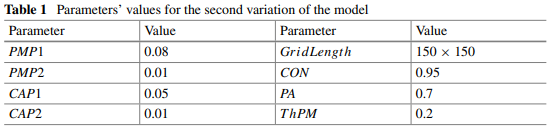

1. Initialiser le modèle : 
    Les paramètres des équations de diffusion sont défini et la topologie des points de départ et des sources de nourriture est introduit grâce à un array depuis une image
2. 
    Appliquer les équations de diffusion pendant 50 itérations (t)
3. 
    Vérifier si les sources de nourritures sont couvertes avec un pourcentage prédéfini de masse du slime
    Si au moins une source de nourriture est couverte :
        Continuer
    Si aucune source de nourriture n'est couverte : 
        Retourner à l'étape 2
4. 
    Toutes les sources de nourriture couvertes avec le pourcentage prédéfini de masse de slime sont encapsulés par le plasmodium et sont donc connectées à un point de départ
5. 
    Les sources de nourritures mentionnées à l'étape 4 se transforment en point de départ, ce qui veut dire que leur masse de slime est définie à 100.
    S'il y a eu moins de 5000 itérations : 
        Retourner à l'étape 2
    Sinon :
        Continuer
6. 
    Redéfinir les cellules "d'intéret" (points de départ et sources de nourriture) en tant que sources de nourriture, sauf les trois dernières sources de nourriture encapsulées dans les 5000 dernières itérations, ceux-ci sont transformés en point de départ

    Répéter les étapes 2 à 5 pour 5000 itérations.

Au départ de l'algorithme : 
    PM (masse de slime) vaut : 
        0 si la case n'est pas une case accessible
        100 si la case est un point de départ
        100 si la case est une source de nourriture ET que la masse de slime sur cette case est supérieure au pourcentage de masse nécessaire prédefini

In [4]:
PAP = 0.7
CON = 0.95
thPM = 0.2 #Masse de slime minimale sur source de nourriture pour qu'il fasse parti du réseau, donnée à modifier
PMP1 = 0.08
PMP2 = 0.01
CAP1 = 0.05
CAP2 = 0.01
class Cell:
    #cell[i,j] = (Espacelibre, MasseSlime, MasseFood, DA, Tube (si la cellule fait partie d'un tube ou non))
    def __init__(self, dispo = 0, mass = float(0), CHA = float(0), da = 0, tube = False):
        self.dispo = dispo #la cellule est dispo ou non, 0 ou 1
        self.mass= mass #masse du slime présente sur la cellule
        self.CHA = CHA #attractivité de la nourriture sur notre cellule CHemoAttractant en pourcentage
        self.da = da #direction entre 0 et 8, 0 si pas de direction, va vers le voisin avec la plus grande mass de slime
        self.tube = tube #la cellule est un tube ou non, bool
        
        #l'état d'une cellule ne prendra pas en compte la direction

    def __repr__(self):
        
        if self.mass != 0:
            return "2" #cellule avec du slime
        elif self.CHA != 0:
            return "3" #cellule avec "odeur" de nourriture
        elif self.dispo == 1:
            return "1" #cellule vide
        
        return "0"     #cellule mur

class Map:
    def __init__(self, imName, diffSlime1, diffSlime2, diffNour1, diffNour2):

        self.diffSlime1=diffSlime1     #parametre 1 de l'équation de diffusion du slime
        self.diffSlime2=diffSlime2     #parametre 2 de l'équation de diffusion du slime
        self.diffNour1=diffNour1       #parametre 1 de l'équation de diffusion de la nourriture
        self.diffNour2=diffNour2       #parametre 2 de l'équation de diffusion de la nourriture
        self.imName = imName           #nom du fichier de l'image
        self.colorMatrix = self.imToMat(self.imName)
        self.grid = self.normalise(self.colorMatrix)
        self.height = len(self.grid)
        self.width = len(self.grid[0])
        
    def __str__(self):
        return str(self.grid)
    
    @staticmethod
    def imToMat(imName):
        im = Image.open(imName + '.png')
        matrice = asarray(im)
        #print(matrice.shape)   #forme de l'array
        #return im
        return matrice
    
    @staticmethod
    def normalise(arrayIm):
        """arrayIm de taille (x, y, z=valeur rgb), on veut return une matrice de taille (x, y)"""
        x, y, _ = arrayIm.shape
        newArray = []

        for i in range(x):
            row = []
            for j in range(y):
                if ((arrayIm[i][j][0] == 0) and (arrayIm[i][j][1] == 0) and (arrayIm[i][j][2] == 0)):  # noir
                    row.append(Cell(dispo=0) ) #représente un mur
                elif arrayIm[i][j][0] == 255 and arrayIm[i][j][1] == 255 and arrayIm[i][j][2] == 255:  # blanc
                    row.append(Cell(dispo=1))  #est un espace libre
                elif arrayIm[i][j][0] == 255 and arrayIm[i][j][1] == 255 and arrayIm[i][j][2] == 0:  # jaune
                    row.append(Cell(dispo=1, mass=100))  #représente une cellule du slime
                elif arrayIm[i][j][0] == 0 and arrayIm[i][j][1] == 0 and arrayIm[i][j][2] == 255:  # bleu
                    row.append(Cell(dispo=1, CHA=100))  #source de nourriture
            newArray.append(row)
        return newArray
    
    def PA(self, i, j, k, l): 
        """
        donne l'Attraction du Physarum de la cellule [i][j] vers une cellule voisine [k][l], k et l différents de i et j
        """
        #print("le CHA sur la case : ",self.grid[k][l].CHA)
        #print("long max : ",len(self.grid))
        #print("larg max : ", len(self.grid[0]))
        CHAvoisins = [] # Liste des voisins de la cellule
        for ni in range(max(0, i-1), min(i+2, len(self.grid))):
            for nj in range(max(0, j-1), min(j+2, len(self.grid[0]))):
                if (ni, nj) != (i, j): # Ne pas inclure la cellule actuelle
                    CHAvoisins.append(self.grid[ni][nj].CHA)
            
        m = i + abs(i-k)
        n = j + abs(j-l)
        
        if k < 0 or k >= len(self.grid) or l < 0 or l >= len(self.grid[0]):
            return 0  # Les indices sont hors des limites de la matrice
        
        if self.grid[k][l].CHA == max(CHAvoisins):
            return PAP
        elif m < 0 or m >= len(self.grid) or n < 0 or n >= len(self.grid[0]):
            return 0  # Les indices sont hors des limites de la matrice
        elif self.grid[m][n].CHA == max(CHAvoisins):
            return -PAP
        return 0
    
    def inMap(self, i, j):
        """
        Vérifie si la case [i][j] existe dans la matrice donnée. Retourne True si la case existe, sinon False
        """
        if i < 0 or i >= self.height or j < 0 or j >= self.width:
            return False  # La case est en dehors des limites de la map
        
        return True  # La case existe
    
    def PMvNN(self, i, j):
        """
        Contribution du voisinage de von Neumann pour la masse du slime sur cellule [i][j]
        """
        haut = 0
        gauche = 0
        bas = 0
        droit = 0
        if self.grid[i][j].dispo == 1: #Vérifie juste qu'on est pas sur un mur. Si c'est le cas la contribution doit être nulle
            if self.inMap(i-1,j):
                haut   = (1 + self.PA( i, j, i-1, j)) * self.grid[i-1][j].mass - self.grid[i-1][j].dispo * self.grid[i][j].mass
            if self.inMap(i,j-1):
                gauche = (1 + self.PA(i, j, i, j-1)) * self.grid[i][j-1].mass - self.grid[i][j-1].dispo * self.grid[i][j].mass
            if self.inMap(i+1,j):
                bas    = (1 + self.PA(i, j, i+1, j)) * self.grid[i+1][j].mass - self.grid[i+1][j].dispo * self.grid[i][j].mass
            if self.inMap(i,j+1):
                droit  = (1 + self.PA(i, j, i, j+1)) * self.grid[i][j+1].mass - self.grid[i][j+1].dispo * self.grid[i][j].mass
            
            #print("contribution PA von Neumann : ",(haut + gauche + droit + bas))
            return (haut + gauche + droit + bas)
        return 0

    def PMeMN(self, i, j):
        """"
        Contribution du voisinage de Moore pour la masse du slime sur cellule [i][j]
        """
        hautgauche=0
        basgauche=0
        hautdroit=0
        basdroit=0
        if self.grid[i][j].dispo == 1:
            if self.inMap(i-1,j-1):
                hautgauche = (1 + self.PA(i, j, i-1, j-1)) * self.grid[i-1][j-1].mass - self.grid[i-1][j-1].dispo * self.grid[i][j].mass
            if self.inMap(i+1,j-1):
                basgauche  = (1 + self.PA(i, j, i+1, j-1)) * self.grid[i+1][j-1].mass - self.grid[i+1][j-1].dispo * self.grid[i][j].mass
            if self.inMap(i-1,j+1):
                hautdroit  = (1 + self.PA(i, j, i-1, j+1)) * self.grid[i-1][j+1].mass - self.grid[i-1][j+1].dispo * self.grid[i][j].mass
            if self.inMap(i+1,j+1):
                basdroit   = (1 + self.PA(i, j, i+1, j+1)) * self.grid[i+1][j+1].mass - self.grid[i+1][j+1].dispo * self.grid[i][j].mass
            
            #print("contribution PA moore : ",(hautgauche + hautdroit + basgauche + basdroit))
            return (hautgauche + hautdroit + basgauche + basdroit)
        return 0
    
    def PM(self, i, j):
        """
        masse de slime totale à t+1 sur la case [i][j]
        """
        #print("masse sur la case {} {} = ".format(i,j), self.grid[i][j].mass)
        return self.grid[i][j].mass + self.diffSlime1 * (self.PMvNN(i, j) + self.diffSlime2 * self.PMeMN(i, j))
    
    def CHAvNN(self, i, j):
        """
        Contribution du voisinage de von Neumann pour la diffusion du chemoattractant sur la case [i][j]
        """
        haut = 0
        gauche = 0
        bas = 0
        droit = 0
        if self.grid[i][j].dispo == 1: #Vérifie juste qu'on est pas sur un mur. Si c'est le cas la contribution doit être nulle
            if self.inMap(i-1,j):
                haut   = (self.grid[i-1][j].CHA - self.grid[i-1][j].dispo) * self.grid[i][j].CHA
            if self.inMap(i,j-1):
                gauche = (self.grid[i][j-1].CHA - self.grid[i][j-1].dispo) * self.grid[i][j].CHA
            if self.inMap(i+1,j):
                bas    = (self.grid[i+1][j].CHA - self.grid[i+1][j].dispo) * self.grid[i][j].CHA
            if self.inMap(i,j+1):
                droit  = (self.grid[i][j+1].CHA - self.grid[i][j+1].dispo) * self.grid[i][j].CHA

        #print("contribution CHA von Neumann : ",(haut + gauche + droit + bas))
        return (haut + bas + droit + gauche)

    def CHAeMN(self, i, j):
        """
        Contribution du voisinage de Moore pour la diffusion du chemoattractant sur la case [i][j]
        """
        hautgauche = 0
        hautdroit = 0
        basgauche = 0
        basdroit = 0
        if self.grid[i][j].dispo == 1: #Vérifie juste qu'on est pas sur un mur. Si c'est le cas la contribution doit être nulle
            if self.inMap(i-1,j-1):
                hautgauche = (self.grid[i-1][j-1].CHA) - self.grid[i-1][j-1].dispo * self.grid[i][j].CHA
            if self.inMap(i+1,j-1):
                hautdroit  = (self.grid[i+1][j-1].CHA) - self.grid[i+1][j-1].dispo * self.grid[i][j].CHA
            if self.inMap(i-1,j+1):
                basgauche  = (self.grid[i-1][j+1].CHA) - self.grid[i-1][j+1].dispo * self.grid[i][j].CHA
            if self.inMap(i+1,j+1):
                basdroit   = (self.grid[i+1][j+1].CHA) - self.grid[i+1][j+1].dispo * self.grid[i][j].CHA

        #print("contribution CHA moore : ",(hautgauche + hautdroit + basgauche + basdroit))
        return (hautgauche + hautdroit + basgauche + basdroit)

    def CHA(self, i, j):
        """
        Attraction chimique sur la case [i][j] à t+1
        """
        return CON * ( self.grid[i][j].CHA + self.diffNour1 * ( self.CHAvNN(i, j) + self.diffNour2 * self.CHAeMN(i, j) ) )

    def diffusionMap(self):
        """
        applique les équations de diffusions sur toute la map pour 1 itération
        """
        i=0
        j=0
        for i in range(self.height):
            for j in range(self.width):
                self.grid[i][j].mass = self.PM(i, j)
                self.grid[i][j].CHA = self.CHA(i, j)
        #print("type de self.grid[i][j].CHA : ", type(self.grid[i][j].CHA))
        #print("type de self.grid[i][j].mass : ", type(self.grid[i][j].mass))

    def afficheMapSlime(self):
        """
        Représentation visuelle des masses de slime sur la map
        """
        row=[]
        col=[]
        for i in range(self.height):
            for j in range(self.width):
                row.append(self.grid[i][j].mass)
            col.append(row)
            row=[]
        print(col)

        #print([[obj.mass for obj in row] for row in self.grid])

    


        


#mat = normalise(ImToMat("test"))
map_obj = Map("test", diffSlime1=PMP1, diffSlime2=PMP2, diffNour1=CAP1, diffNour2=CAP2)
#print(map_obj.PA(0,8,0,7))
#print(map_obj.PM(1,7))
#print(map_obj.CHA(0,9))
map_obj.afficheMapSlime() #iteration 0
map_obj.diffusionMap()
map_obj.afficheMapSlime() #iteration 1, après les équations de diffusion




[[0.0, 0.0, 100, 0.0, 100, 100, 0.0, 100, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 100, 100, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[0.0, 0.0, 83.92, 19.49312, 105.90706432, 104.05936074752, 27.888073061662723, 86.15104584493302, 0.0, 0.0], [0.0, 0.067136, 6.738324992000001, 0.0, 112.01139212133663, 113.40758377700357, 0.0, 6.914394126043971, 0.6220723667594641, 0.04976578934075713], [9.130496e-05, 0.014528460390400002, 0.540319581151232, 0.0, 0.0, 0.0, 0.0, 0.5539975485023105, 0.13449297369177973, 0.01558671946139582], [2.4040242872320003e-05, 0.0018991588557730613, 0.07364701851334171, 0.0, 0.0, 0.0, 

In [17]:
class App(tk.Tk):
    def __init__(self):
        super().__init__()
        
        self.title("App Slime")
        self.geometry("900x500")
        self.resizable(True, True)
        self.iconphoto(False, tk.PhotoImage(file="test.png"))

if __name__ == "__main__":
    app = App()
    app.mainloop()

In [6]:
def PA(self, cell : Cell, i, j, k, l): 
    """donne l'Attraction du Physarum de la cellule [i][j] vers une cellule voisine [k][l], 
    k et l différents de i et j"""

    CHAvoisins = [ self.grid[i-1][j-1], self.grid[i-1][j], self.grid[i-1][j+1], 
                   self.grid[i][j-1]  , self.grid[i][j]  , self.grid[i][j+1]  ,
                   self.grid[i+1][j-1], self.grid[i+1][j], self.grid[i+1][j+1] ] #matrice des voisins de la cellule
    m = i + abs(i-k)
    n = j + abs(j-l)
    if self.grid[k][l] == max(CHAvoisins):
        return PAP
    elif self.grid[m][n] == max(CHAvoisins):
        return -PAP
    else:
        return 0

In [7]:
def PMvNN(self, cell : Cell, i, j):
    """Contribution du voisinage de von Neumann pour la masse du slime sur cellule [i][j]"""
    return (  (1 + PA(Cell, i, j, i-1, j)) * Cell.mass[i-1][j] - Cell.dispo[i-1][j] * Cell.mass[i][j]
            + (1 + PA(Cell, i, j, i, j-1)) * Cell.mass[i][j-1] - Cell.dispo[i][j-1] * Cell.mass[i][j]
            + (1 + PA(Cell, i, j, i+1, j)) * Cell.mass[i+1][j] - Cell.dispo[i+1][j] * Cell.mass[i][j]
            + (1 + PA(Cell, i, j, i, j+1)) * Cell.mass[i][j+1] - Cell.dispo[i][j+1] * Cell.mass[i][j] )

def PMeMN(self, Cell, i, j):
    """"Contribution du voisinage de Moore pour la masse du slime sur cellule [i][j]"""
    return (  (1 + PA(Cell, i, j, i-1, j-1)) * Cell.mass[i-1][j-1] - Cell.dispo[i-1][j-1] * Cell.mass[i][j]
            + (1 + PA(Cell, i, j, i+1, j-1)) * Cell.mass[i+1][j-1] - Cell.dispo[i+1][j-1] * Cell.mass[i][j]
            + (1 + PA(Cell, i, j, i-1, j+1)) * Cell.mass[i-1][j+1] - Cell.dispo[i-1][j+1] * Cell.mass[i][j]
            + (1 + PA(Cell, i, j, i+1, j+1)) * Cell.mass[i+1][j+1] - Cell.dispo[i+1][j+1] * Cell.mass[i][j] )
    
def PM(self, Cell, i, j, PMP1, PMP2):
    """masse de slime totale à t+1 sur la case [i][j]"""
    return Cell.mass[i][j] + PMP1 * (PMvNN(Cell, i, j) + PMP2 * PMeMN(Cell, i, j))

In [8]:
def CHAvNN(self, cell : Cell, i, j):
    """Contribution du voisinage de von Neumann pour la diffusion du chemoattractant sur la case [i][j]"""
    return (  (self.grid[i-1][j]) - Cell.dispo[i-1][j] * self.grid[i][j]
            + (self.grid[i][j-1]) - Cell.dispo[i][j-1] * self.grid[i][j]
            + (self.grid[i+1][j]) - Cell.dispo[i+1][j] * self.grid[i][j]
            + (self.grid[i][j+1]) - Cell.dispo[i][j+1] * self.grid[i][j] )

def CHAeMN(self, cell : Cell, i, j):
    """Contribution du voisinage de Moore pour la diffusion du chemoattractant sur la case [i][j]"""
    return (  (self.grid[i-1][j-1]) - Cell.dispo[i-1][j-1] * self.grid[i][j]
            + (self.grid[i+1][j-1]) - Cell.dispo[i+1][j-1] * self.grid[i][j]
            + (self.grid[i-1][j+1]) - Cell.dispo[i-1][j+1] * self.grid[i][j]
            + (self.grid[i+1][j+1]) - Cell.dispo[i+1][j+1] * self.grid[i][j] )

def CHA(self, cell : Cell, i, j, CAP1, CAP2):
    """Attraction chimique sur la case [i][j] à t+1"""
    return CON * ( self.grid[i][j] + CAP1 * ( CHAvNN(Cell, i, j) + CAP2 * CHAeMN(Cell, i, j) ) )

In [9]:
def ImToMat(ImName):
    im = Image.open(ImName + '.png')
    matrice = asarray(im)
    #print(matrice.shape)   #forme de l'array
    #return im
    return matrice

ImToMat("test")
#Image.open('maze.png')

class Cell:
    #cell[i,j] = (Espacelibre, MasseSlime, MasseFood, DA, Tube (si la cellule fait partie d'un tube ou non))
    def __init__(self, dispo = 1, mass = 0, CHA = float(0), da = 0, tube = False):
        self.dispo = dispo #la cellule est dispo ou non, 0 ou 1
        self.mass= mass #masse du slime présente sur la cellule
        self.CHA = CHA #attractivité de la nourriture sur notre cellule CHemoAttractant en pourcentage
        self.da = da #direction entre 0 et 8, 0 si pas de direction, va vers le voisin avec la plus grande mass de slime
        self.tube = tube #la cellule est un tube ou non, bool
        
    def __repr__(self):
        
        if self.mass != 0:
            return "2"
        elif self.CHA != 0:
            return "3"
        elif self.dispo == 1:
            return "1"
        return "0"
        
def normalise(arrayIm):
    """arrayIm de taille (x, y, z), on veut return une matrice de taille (x, y)"""
    x, y, _ = arrayIm.shape
    newArray = []

    for i in range(x):
        row = []
        for j in range(y):
            if ((arrayIm[i][j][0] == 0) and (arrayIm[i][j][1] == 0) and (arrayIm[i][j][2] == 0)):  # noir
                row.append(Cell(dispo=0) ) # 3 représente un mur
            elif arrayIm[i][j][0] == 255 and arrayIm[i][j][1] == 255 and arrayIm[i][j][2] == 255:  # blanc
                row.append(Cell(dispo=1))  # 0 est un espace libre
            elif arrayIm[i][j][0] == 255 and arrayIm[i][j][1] == 255 and arrayIm[i][j][2] == 0:  # jaune
                row.append(Cell(dispo=1, mass=100))  # représente une cellule du slime
            elif arrayIm[i][j][0] == 0 and arrayIm[i][j][1] == 0 and arrayIm[i][j][2] == 255:  # bleu
                row.append(Cell(dispo=1, CHA=100))  # source de nourriture
        newArray.append(row)

    return newArray

mat = normalise(ImToMat("test"))
map_obj = Map("test", 100, 100, 100, 100)
print(map_obj)




[[3, 0, 2, 1, 2, 2, 1, 2, 0, 3], [1, 3, 1, 0, 2, 2, 0, 1, 3, 1], [1, 1, 1, 0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
